A ideia desse notebook é calcular a rugosidade de uma superficie com base nos dados extraidos de um perfilometro, para isso, é preciso abrir o arquivo .OPDx que o equipamento cria e tratar os dados para que a nuvem de pontos esteja na melhor condição para executar os calculos.

As proximas celulas é a implentação de um modulo (peguei o código todo por problemas na instalação automatica do modulo) que faz a leitura do arquivo OPDx e extrai a nuvem de pontos medidos.

github do modulo: https://github.com/ThibaultCapelle/OPDx_read

In [1]:
import numpy as np
import struct
import ctypes as ct
import matplotlib.pylab as plt

MAGIC=b'VCA DATA\x01\x00\x00U' #This sequence is the beginning of each file
MAGIC_SIZE=12
DEBUG=False

class DektakItem:
    
    def __init__(self, name=None, data_type=None, data=None):
        self.name=name
        self.data_type=data_type
        self.data=data

class DektakLoad:
    data_types=dict({'DEKTAK_MATRIX'       : 0x00, # Too lazy to assign an actual type id?
                    'DEKTAK_BOOLEAN'      : 0x01, # Takes value 0 and 1 */
                    'DEKTAK_SINT32'       : 0x06,
                    'DEKTAK_UINT32'       : 0x07,
                    'DEKTAK_SINT64'       : 0x0a,
                    'DEKTAK_UINT64'       : 0x0b,
                    'DEKTAK_FLOAT'        : 0x0c, # Single precision float */
                    'DEKTAK_DOUBLE'       : 0x0d, # Double precision float */
                    'DEKTAK_TYPE_ID'      : 0x0e, # Compound type holding some kind of type id */
                    'DEKTAK_STRING'       : 0x12, # Free-form string value */
                    'DEKTAK_QUANTITY'     : 0x13, # Value with units (compound type) */
                    'DEKTAK_TIME_STAMP'   : 0x15, # Datetime (string/9-byte binary) */
                    'DEKTAK_UNITS'        : 0x18, # Units (compound type) */
                    'DEKTAK_DOUBLE_ARRAY' : 0x40, # Raw data array, in XML Base64-encoded */
                    'DEKTAK_STRING_LIST'  : 0x42, # List of Str */
                    'DEKTAK_ANON_MATRIX'  : 0x45, # Like DEKTAK_MATRIX, but with no name. */
                    'DEKTAK_RAW_DATA'     : 0x46, # Parent/wrapper tag of raw data */
                    'DEKTAK_RAW_DATA_2D'  : 0x47, # Parent/wrapper tag of raw data */
                    'DEKTAK_POS_RAW_DATA' : 0x7c, # Base64-encoded positions, not sure how
                                                  # it differs from 64 */
                    'DEKTAK_CONTAINER'    : 0x7d, # General nested data structure */
                    'DEKTAK_TERMINATOR'   : 0x7f # Always the last item.
                                                   #Usually a couple of 0xff bytes inside. */
                                                   })
    
    def __init__(self,filename):
        self.filename=filename
        self.items=[]
        self.reading_2D=False
        self.reading_1D=False
        self.terminator=False
        self.current_count=0
        with open(self.filename, 'rb') as f:
            f.seek(0,2)
            self.eof=f.tell()
            f.seek(0,0)
        self.read()
    
    def read_varlen(self, f):
        length=int.from_bytes(f.read(1),"big")
        if length==1:
            return int.from_bytes(f.read(1),"big")
        elif length==2:
            return int.from_bytes(f.read(2),"big")
        elif length==4:
            return int.from_bytes(f.read(4),"big")
        else:
            print('The varlength format was not respected')
            return -1
    
    def read_structured(self, item, f):
        self.read_varlen(f)
        item.data=dict()
        item.data['items']=[]
        last_item=self.read_item(f)
        while(not self.terminator and last_item is not None):
            item.data['items'].append(last_item)
            last_item=self.read_item(f)
        self.terminator=False
        return item
    
    def read_name(self, f):
        data=f.read(4)
        length=struct.unpack('i',data)[0]
        return f.read(length).decode()
            

    
    def read_item(self, f):
        if f.tell()==self.eof:
            return None
        
        
        item=DektakItem()
        item.name=self.read_name(f)
        datatype=f.read(1)
        if DEBUG:
            print('the datatype of this item is: {:}'.format(datatype))
        item.data_type=int.from_bytes(datatype, "big")
        if item.data_type==DektakLoad.data_types['DEKTAK_BOOLEAN']:
            item.data=f.read(1)
        elif item.data_type==DektakLoad.data_types['DEKTAK_SINT32']:
            item.data=struct.unpack('I',f.read(4))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_UINT32']:
            item.data=struct.unpack('I',f.read(4))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_SINT64']:
            data=f.read(8)
            item.data=struct.unpack('Q',data)[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_UINT64']:
            item.data=struct.unpack('Q',f.read(8))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_FLOAT']:
            item.data=struct.unpack('f',f.read(4))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_DOUBLE']:
            item.data=struct.unpack('d',f.read(8))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_TIME_STAMP']:
            item.data=f.read(9)
        elif item.data_type==DektakLoad.data_types['DEKTAK_STRING']:
            length=self.read_varlen(f)
            item.data=f.read(length).decode()
        elif item.data_type==DektakLoad.data_types['DEKTAK_STRING_LIST']:
            item.data=dict()
            item.data['datatype']=self.read_name(f)
            length=self.read_varlen(f)
            item.data['strings']=[self.read_name(f)]
        elif item.data_type==DektakLoad.data_types['DEKTAK_DOUBLE_ARRAY']:
            item.data=dict()
            item.data['datatype']=self.read_name(f)
            f.read(8)
            item.data['data']=np.frombuffer(f.read(self.current_count*8),
                     dtype=float)
        elif item.data_type==DektakLoad.data_types['DEKTAK_UNITS']:
            item.data=dict()
            item.data['length']=self.read_varlen(f)
            item.data['name']=self.read_name(f)
            item.data['symbol']=self.read_name(f)
            item.data['value']=struct.unpack('d',f.read(8))[0]
            f.read(12)
        elif item.data_type==DektakLoad.data_types['DEKTAK_QUANTITY']:
            item.data=dict()
            item.data['length']=self.read_varlen(f)
            item.data['value']=struct.unpack('d',f.read(8))[0]
            item.data['name']=self.read_name(f)
            item.data['symbol']=self.read_name(f)
            if len(item.data['name'])>0:
                f.read(20)
            else:
                f.read(16)
        elif item.data_type==DektakLoad.data_types['DEKTAK_TERMINATOR']:
            self.reading_2D=False
            self.reading_1D=False
            self.terminator=True
            item.data=f.read(2)
        elif item.data_type==DektakLoad.data_types['DEKTAK_TYPE_ID']:
            item.data=dict()
            item.data['name']=self.read_name(f)
            length=self.read_varlen(f)
            item.data['value']=int.from_bytes(f.read(length), 'little')
        elif item.data_type==DektakLoad.data_types['DEKTAK_POS_RAW_DATA']:
            if self.reading_2D:
                item.data=dict()
                item.data['name']=self.read_name(f)
                item.data['length']=self.read_varlen(f)
                item.data['value_x']=struct.unpack('d',f.read(8))[0]
                item.data['unit_name_x']=self.read_name(f)
                item.data['unit_symbol_x']=self.read_name(f)
                item.data['divisor_x']=struct.unpack('d',f.read(8))[0]
                f.read(12)
                item.data['value_y']=struct.unpack('d',f.read(8))[0]
                item.data['unit_name_y']=self.read_name(f)
                item.data['unit_symbol_y']=self.read_name(f)
                item.data['divisor_y']=struct.unpack('d',f.read(8))[0]
                f.read(12)
            elif self.reading_1D:
                item.data=dict()
                item.data['name']=self.read_name(f)
                item.data['length']=self.read_varlen(f)
                item.data['unit_name']=self.read_name(f)
                item.data['unit_symbol']=self.read_name(f)
                item.data['divisor']=struct.unpack('d',f.read(8))[0]
                f.read(12)
                item.data['count']=struct.unpack('Q',f.read(8))[0]
                self.current_count=item.data['count']
                N=item.data['length']
                N=item.data['count']
                item.data['data']=np.frombuffer(f.read(N*8), dtype=float)
                
        elif item.data_type==DektakLoad.data_types['DEKTAK_ANON_MATRIX']:
            item.data=dict()
            item.data['name']=self.read_name(f)
            item.data['size']=self.read_varlen(f)
            item.data['yres']=struct.unpack('I',f.read(4))[0]
            item.data['xres']=struct.unpack('I',f.read(4))[0]
            if item.data['size']<2*ct.sizeof(ct.c_uint32):
                print('PROBLEM')
            item.data['size']-=2*ct.sizeof(ct.c_uint32)
            N=item.data['xres']*item.data['yres']
            data=f.read(4*N)
            item.data['data']=np.reshape(np.frombuffer(data,
                     dtype="float32"), (item.data['yres'],
                                    item.data['xres']))
            
            
        elif item.data_type==DektakLoad.data_types['DEKTAK_MATRIX']:
            item.data=dict()
            item.data['name']=f.read(4)
            item.data['size']=self.read_varlen(f)
            item.data['xres']=struct.unpack('I',f.read(4))[0]
            item.data['yres']=struct.unpack('I',f.read(4))[0]
            if item.data['size']<2*ct.sizeof(ct.c_uint32):
                print('PROBLEM')
            item.data['size']-=2*ct.sizeof(ct.c_uint32)
        elif item.data_type==DektakLoad.data_types['DEKTAK_CONTAINER']:
            if item.name=='1D_Data':
                self.reading_1D=True
            elif item.name=='2D_Data':
                self.reading_2D=True
            item=self.read_structured(item, f)
        elif item.data_type==DektakLoad.data_types['DEKTAK_RAW_DATA']:
            item=self.read_structured(item, f)
        elif item.data_type==DektakLoad.data_types['DEKTAK_RAW_DATA_2D']:
            item=self.read_structured(item, f)
        else:
            print('unknown data_type')
            print(f.read(100))
            print(item.data_type)
        if DEBUG:
            print('{:},{:},{:}===>>>>{:} ; {:}'.format(item.data_type,
              f.tell(), datatype, item.name, item.data))
        return item
            
        
    def read(self):
        with open(self.filename, 'rb') as f:
            while(f.tell()!=MAGIC_SIZE):
                f.read(1)
            while(len(self.items)<10):
                item=self.read_item(f)
                self.items.append(item)
    
    def get_data_1D(self):
        x,y,scale, divisor=None, None, None, None
        for item in self.items:
            if item is not None:
                if item.name=='1D_Data':
                    break
        subitem=None
        for k in item.data['items']:
            if k.name=='Raw':
                subitem=k
                break
        if subitem is not None:
            for k in subitem.data['items']:
                if k.name=='PositionFunction':
                    x=k.data['data']
                    divisor=k.data['divisor']
                elif k.name=='Array':
                    y=k.data['data']
                elif k.name=='DataScale':
                    scale=k.data['value']
            return x/divisor, y*scale/divisor
        else:
            return None, None
    
    def get_data_2D(self, plot=True):
        for item in self.items:
            if item is not None:
                if item.name=='2D_Data':
                    break
        subitem=None
        for k in item.data['items']:
            if k.name=='Raw':
                subitem=k
                break
        if subitem is not None:
            divisor=1
            for mat in subitem.data['items']:
                if mat.name=='Matrix':
                    break
            for scale in subitem.data['items']:
                if scale.name=='DataScale':
                    if scale.data['name']=='Micrometer':
                        divisor=1e6
                    break
            for dim1 in subitem.data['items']:
                if dim1.name=='Dimension1Extent':
                    break
            for dim2 in subitem.data['items']:
                if dim2.name=='Dimension2Extent':
                    break
            for subsubitem in subitem.data['items']:
                if subsubitem.name=='PositionFunction':
                    symbol_x, symbol_y=(subsubitem.data['unit_symbol_x'] + 'x',
                                        subsubitem.data['unit_symbol_y'] + 'y')
                    break
            if plot:
                plt.imshow(mat.data['data']*scale.data['value'],
                           extent=[0,dim2.data['value'],
                                   0,dim1.data['value']])
                plt.xlabel(symbol_x)
                plt.ylabel(symbol_y)
            zs=mat.data['data']*scale.data['value']/divisor
            xs=np.linspace(0, dim2.data['value'],
                           np.shape(mat.data['data'])[1])
            ys=np.linspace(0, dim1.data['value'],
                           np.shape(mat.data['data'])[0])
            return (xs, ys, zs)
        else:
            return None, None, None
    
    def get_metadata(self):
        for item in self.items:
            if item is not None:
                if item.name=='MetaData':
                    break
        res=dict()
        for k in item.data['items']:
            if not isinstance(k.data, dict):
                res[k.name]=k.data
            else:
                res[k.name]=dict()
                for child in k.data['items']:
                    res[k.name][child.name]=child.data
        return res

Aqui estou utilizando o modulo "OPDx_read" para importar os 3 vetores de dados que contem no arquivo .OPDx.
O metodo "get_data_2D" retorna 2 vetores com as distancias de comprimento e largura e uma matriz de ordem comprimento x largura com a altura de cada ponto medido.

Aproveito tambem para importar os modulos restantes do projeto, pandas para estatistica, seaborn e matplotlib para vizualização dos dados e numpy para realizar os cálculos

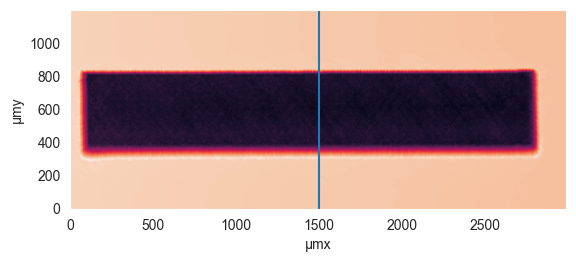

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np   

corte = 150  #Perfil 1D de corte

sns.set_style('dark')
sns.set_palette('tab10')

loader = DektakLoad('T1A/T1A_90graus_Positivo.OPDx')
x,y,z = loader.get_data_2D()

plt.axvline(x[corte])
plt.show()

Considerações gerais para o tratamento dos dados nas proximas celulas:

 - Optei por utilizar Pandas Series ao invés de listas padrões do python por conta da facilidade de extrair os calculos estatisticos.
 - Analisando os dois perfis de corte que podem aparecer, é possivel fazer a diferenciação por meio da média de cada um
 - Todas as curvas serão divididas em 5 seções para realização de calculos e normalização da curva

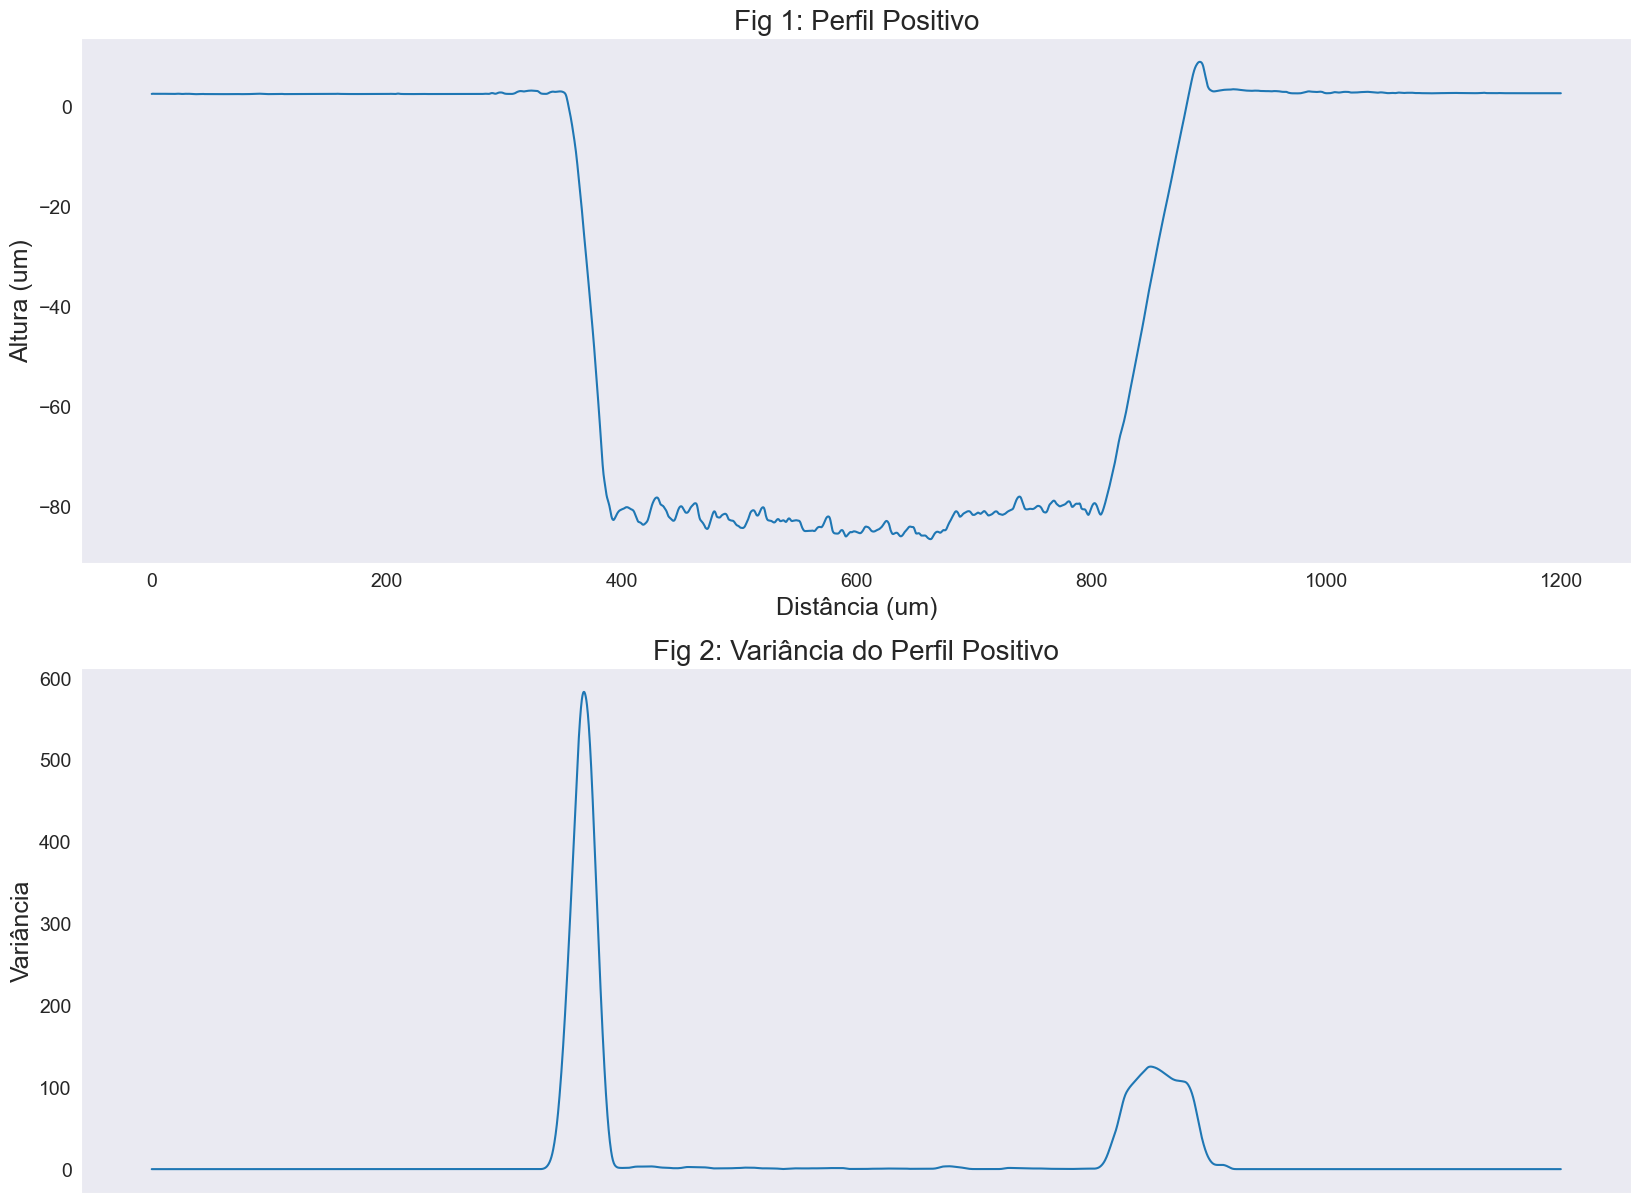

In [3]:
altura = pd.Series()        #Lista onde é armazenado as alturas do perfil selecionado, utilizei o pandas por conta da facilidade de fazer calculos estatisticos
aux = pd.Series()           #Lista auxiliar para armazenar dados temporarios que construirão a curva de variancia do perfil
altura_var = pd.Series()    #Lista que armazenará a variância 
pontos = 125                #Quantidade de pontos que a logica de varredura percorre para calcular a variancia


#Varre todos os pontos da linha de "corte" da matriz Z
for i in range(len(y)):
    altura[i] = ((z[i][corte]*1000000))

#identificando o tipo de Perfil
if altura.mean() > 0:
    Perfil = "Negativo"
else:
    Perfil = "Positivo"

#Laço que varre 'n' pontos para calcular a variancia local, sempre se deslocando 1 ponto para o final da curva
for i in range(len(altura)-pontos):
    for j in range(pontos):
        aux[j] = altura[i+j]
    altura_var[i] = aux.var()

#Plots
figure = 0                   #Variavel que conta as imagens geradas ao longo do código


fig, axs = plt.subplots(ncols=1,nrows=2, figsize=(20, 15))

sns.lineplot(y= altura, x = y, ax = axs[0])
figure += 1
axs[0].set_title("Fig %d: Perfil %s"%(figure, Perfil), fontsize = 20)
axs[0].set_ylabel("Altura (um)", fontsize = 18)
axs[0].set_xlabel("Distância (um)", fontsize = 18)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].yaxis.set_tick_params(labelsize=14)


sns.lineplot(altura_var, ax = axs[1])
figure +=1
axs[1].set_title("Fig %d: Variância do Perfil %s"%(figure, Perfil), fontsize = 20)
axs[1].set_ylabel("Variância", fontsize = 18)
axs[1].set_xlabel(None)
axs[1].set_xticks([])
axs[1].yaxis.set_tick_params(labelsize=14)



plt.show()

Comparando as figuras 1 e 2 é possivel observar que os picos de variancia se alinham com o as "paredes" do perfil, isso ajuda na identificação dos pontos para a seleção da região de interesse para efetuar os cálculos de rugosidade.

O próximo passo é separar os indices do vetor "altura_var" onde o valor da variância é acima do terceiro quartil, nesse corte conseguimos evitar selecinar as superficies planas do substrato.

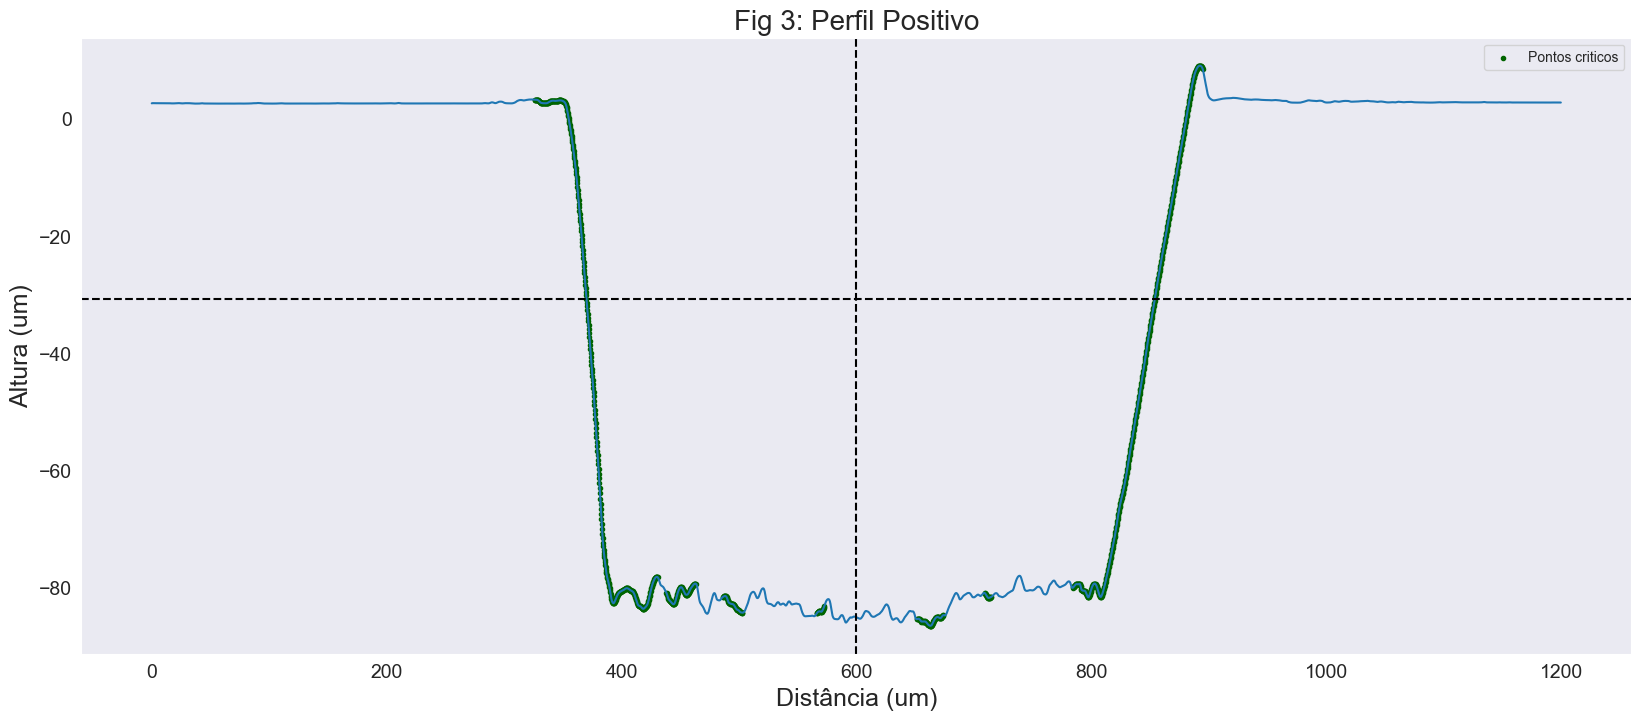

In [4]:
indices_criticos = []                               #Vetor que armazena os pontos criticos da curva


#laço que varre o vetor da variancia e quando o valor no indice "i" for maior que o terceiro quartil, armazena o indice no vetor "indices_criticos"
for i in range(len(altura_var)):
    if altura_var[i] > altura_var.quantile(q = 0.75):
        indices_criticos.append(i)


#plot
ax = sns.lineplot(y = altura, x = y)
ax.figure.set_size_inches(20,8)
figure+=1
ax.set_title("Fig %d: Perfil %s"%(figure, Perfil), fontsize = 20)
ax.set_xlabel("Distância (um)",  fontsize = 18)
ax.set_ylabel("Altura (um)",  fontsize = 18)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

#laço para plotar todos os pontos identificados na primeira varredura
for i in range(len(indices_criticos)):
    if i == (len(indices_criticos) - 1):
        plt.scatter(x=y[indices_criticos[i]], y = altura[indices_criticos[i]] ,c='darkgreen', s = 9, label = 'Pontos criticos')
    else:    
        plt.scatter(x=y[indices_criticos[i]], y = altura[indices_criticos[i]] ,c='darkgreen', s = 9)
        
plt.axvline(y.mean(), color = 'black', linestyle = '--')
plt.axhline(altura.mean(), color = 'black', linestyle = '--')
plt.legend(loc = 'upper right')
plt.show()

No gráfico acima podemos visualizar todos os pontos identificados pelo calculo de variancia como "Criticos". Note a divisão de quadrantes, para nós os pontos importantes estão na metade inferior, e existe a divisão direita e esquerda para facilitar na identificação das seções.

Nas células abaixo criei a função "AchaMenor" que é utilizada em dois momentos ao longo do código para identificar o menor valor dentro de um vetor, sendo fundamental para divisão de seções.

In [5]:
def AchaMenor(beta, alcance, div):
    m=0                                                         #Variavel de suporte, utilizada como contagem no laço while
    indice_menor = 0                                            #Variavel alvo da função, local onde é armazenado o indice do vetor "beta" que contem o menor valor do vetor "beta"
    
    excluidos = pd.Series()                                     #Vetor de suporte utilizado para não perder a quantidade de indices que são "cortados" do vetor "beta"

    #Laço que varre os primeiros "n (alcance)" valores do vetor "beta" e os compara com a média do vetor das alturas do perfil, valores maiores que a média são excluidos
    for i in range(alcance):
            if beta[i] > altura.mean():
                excluidos[i] = beta[i]
                beta.pop(i)
    beta.reset_index(drop = True, inplace = True)
    
    #Laço que percorre o novo vetor "beta" e compara os valores dentro dele pra identificar o indice onde está o menor valor
    while m < alcance/div:
        if beta[m] < beta[indice_menor]:
            indice_menor = m
        else:
            indice_menor = indice_menor
        m = m + 1

    return (indice_menor + len(excluidos))

A partir deste ponto é necessario dividir os calculos para as curvas "positivas e negativas", a lógica é basicamente a mesma mas com algumas inversões de sinais por conta da direção do vetor das curvas

In [6]:
#Calculos para separar as seções do Perfil Negativo
if Perfil == 'Negativo':
   alcance_maiores = []                                                    #Vetor que armazena a quantidade de números que estão posicionados no quadrante inferior direito da figura 3
   alcance_menores = []                                                    #Vetor que armazena a quantidade de números que estão posicionados no quadrante inferior esquerdo da figura 3

   #Laço que percorre os pontos criticos e faz a separação dos pontos de acordo com o quadrante da figura 3
   for i in range(len(indices_criticos)):
      if y[indices_criticos[i]] > int(y.mean()):
         alcance_maiores.append(i)
      else:
         alcance_menores.append(i)
      
   beta = pd.Series()                                                      #Vetor auxiliar que armazena os valores que são enviados para dentro da função "AchaMenor"

   #Laço para preencher o vetor "beta" com os valores maiores que a média
   for i in range(len(alcance_maiores)):
      beta[i] = altura[indices_criticos[alcance_maiores[i]]]
   menor = AchaMenor(beta, len(alcance_maiores),3)                         #Variavel que armazena o retorno da função "AchaMenor"

   secao5_comeca = indices_criticos[alcance_maiores[menor]]                #Variavel que armazena o ponto em que a seção 5 começa
   secao4_termina = indices_criticos[alcance_maiores[menor]] - 1           #Variavel que armazena o ponto em que a seção 4 termina


   beta = pd.Series()                                                      #Vetor auxiliar que armazena os valores que são enviados para dentro da função "AchaMenor"

   #Laço para preencher o vetor "beta" com os valores menores que a média
   for i in range(len(alcance_menores)):
      beta[i] = altura[indices_criticos[alcance_menores[i]]]
      
   menor = AchaMenor(beta,len(alcance_menores),3)                         #Variavel que armazena o retorno da função "AchaMenor"
   
   secao1_termina = indices_criticos[alcance_menores[-1*menor]]           #Variavel que armazena o ponto em que a seção 1 termina
   secao2_comeca = indices_criticos[alcance_menores[-1*menor]] + 1        #Variavel que armazena o ponto em que a seção 2 começa


   secao1_comeca = 0                                                      #Variavel que armazena o ponto em que a seção 1 começa
   secao2_termina = indices_criticos[alcance_menores[-1]]                 #Variavel que armazena o ponto em que a seção 2 termina
   secao3_comeca = indices_criticos[alcance_menores[-1]] + 1              #Variavel que armazena o ponto em que a seção 3 começa
   secao3_termina = indices_criticos[alcance_maiores[0]] - 1              #Variavel que armazena o ponto em que a seção 3 termina
   secao4_comeca = indices_criticos[alcance_maiores[0]]                   #Variavel que armazena o ponto em que a seção 4 começa
   secao5_termina = len(y)-1                                              #Variavel que armazena o ponto em que a seção 5 termina


#Calculos para separar as seções do Perfil Positivo.
if Perfil == 'Positivo':

   #Mesma lógica e mesmas variaveis do calculo para o perfil negativo.

   alcance_maiores = []
   alcance_menores = []

   for i in range(len(indices_criticos)):
      if y[indices_criticos[i]] > int(y.mean()):
         alcance_maiores.append(i)
      else:
         alcance_menores.append(i)

   beta = pd.Series()
   for i in range(len(alcance_maiores)):
      beta[i] = altura[indices_criticos[i]]

   menor = AchaMenor(beta, len(alcance_maiores), 3)
   
   secao2_termina = indices_criticos[menor] - 1
   secao3_comeca = indices_criticos[menor]

   beta = pd.Series()
   for i in range(len(alcance_menores)):
      beta[i] = altura[indices_criticos[i]]

   menor = AchaMenor(beta, len(alcance_menores), 3)

   secao3_termina = indices_criticos[-1*menor] - 1
   secao4_comeca = indices_criticos[-1*menor]

   secao1_comeca = 0
   secao1_termina = indices_criticos[0]- 1
   secao2_comeca = indices_criticos[0]
   secao4_termina = indices_criticos[-1] - 1
   secao5_comeca = indices_criticos[-1] 
   secao5_termina = len(y)-1

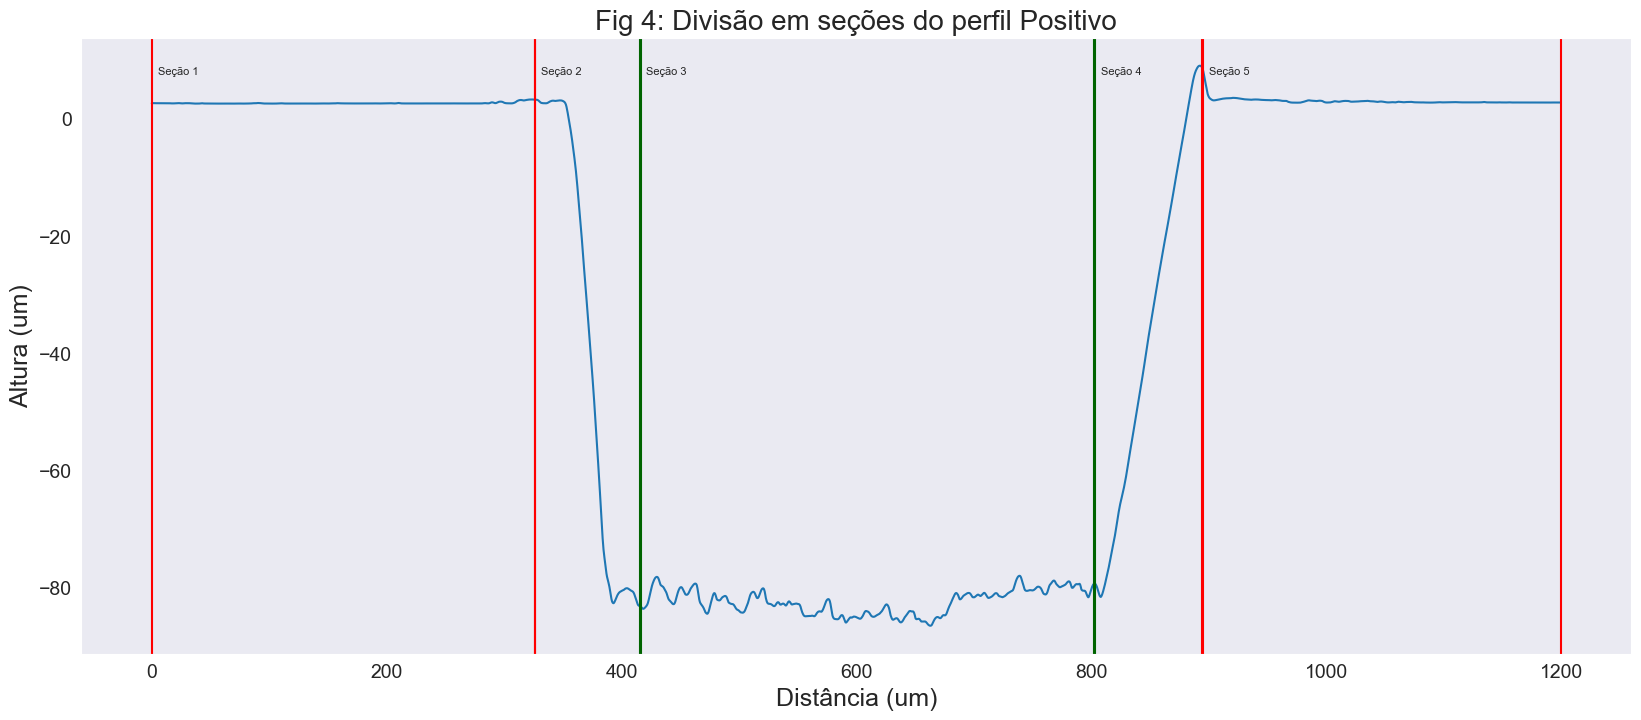

In [7]:
#Bloco de plot da curva com as seções dos perfis identificadas

if Perfil == 'Negativo':
    ax = sns.lineplot(y = altura, x = y)
    figure += 1
    ax.figure.set_size_inches(20,8)
    ax.set_title("Fig %d: Divisão em seções do perfil %s"%(figure, Perfil), fontsize = 20)
    ax.set_ylabel("Altura (um)", fontsize = 18)
    ax.set_xlabel("Distância (um)", fontsize = 18)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)

    plt.axvline(y[secao1_comeca], color = 'g')
    plt.axvline(y[secao1_termina], color = 'g')
    plt.axvline(y[secao2_comeca], color = 'g')
    plt.axvline(y[secao2_termina], color = 'r')
    plt.axvline(y[secao3_comeca], color = 'r')
    plt.axvline(y[secao3_termina], color = 'r')
    plt.axvline(y[secao4_comeca], color = 'r')
    plt.axvline(y[secao4_termina], color = 'r')
    plt.axvline(y[secao5_comeca], color = 'g')
    plt.axvline(y[secao5_termina], color = 'g')

    plt.text(x = y[secao1_comeca]+5, y = (altura[0]+44), s="Seção 1", fontsize = '8')
    plt.text(x = y[secao2_comeca]+5, y = (altura[0]+44), s="Seção 2", fontsize = '8')
    plt.text(x = y[secao3_comeca]+5, y = (altura[0]+44), s="Seção 3", fontsize = '8')
    plt.text(x = y[secao4_comeca]+5, y = (altura[0]+44), s="Seção 4", fontsize = '8')
    plt.text(x = y[secao5_comeca]+5, y = (altura[0]+44), s="Seção 5", fontsize = '8')
    plt.show()

if Perfil == 'Positivo':
    ax = sns.lineplot(y = altura, x = y)
    figure += 1
    ax.figure.set_size_inches(20,8)
    ax.set_title("Fig %d: Divisão em seções do perfil %s"%(figure, Perfil), fontsize = 20)
    ax.set_ylabel("Altura (um)", fontsize = 18)
    ax.set_xlabel("Distância (um)", fontsize = 18)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)


    plt.axvline(y[secao1_comeca], color = 'r')
    plt.axvline(y[secao1_termina], color = 'r')
    plt.axvline(y[secao2_comeca], color = 'r')
    plt.axvline(y[secao2_termina], color = 'darkgreen')
    plt.axvline(y[secao3_comeca], color = 'darkgreen')
    plt.axvline(y[secao3_termina], color = 'darkgreen')
    plt.axvline(y[secao4_comeca], color = 'darkgreen')
    plt.axvline(y[secao4_termina], color = 'r')
    plt.axvline(y[secao5_comeca], color = 'r')
    plt.axvline(y[secao5_termina], color = 'r')

    plt.text(x = y[secao1_comeca]+5, y = (altura[0]+5), s="Seção 1", fontsize = '8')
    plt.text(x = y[secao2_comeca]+5, y = (altura[0]+5), s="Seção 2", fontsize = '8')
    plt.text(x = y[secao3_comeca]+5, y = (altura[0]+5), s="Seção 3", fontsize = '8')
    plt.text(x = y[secao4_comeca]+5, y = (altura[0]+5), s="Seção 4", fontsize = '8')
    plt.text(x = y[secao5_comeca]+5, y = (altura[0]+5), s="Seção 5", fontsize = '8')
    plt.show()


Na figura 4 ja temos as seções divididas. Agora precisamos fazer mais dois tratamentos nos dados antes de utiliza-los para calcular a rugosidade:
- o primeiro é normalizar a curva, existe um desnivel do primeiro ponto do grafico em relação ao último por conta da maneira que é realizado o processo no equipamento de perfilômetria.
- o segundo é ajustar a seção que contem os dados para os calculos, nem sempre o corte fica na melhor posição, então é preciso caminhar alguns pontos pra trás e pra frente, com a finalidade de ajustar a seção selecionada da forma que melhor representa a realidade.

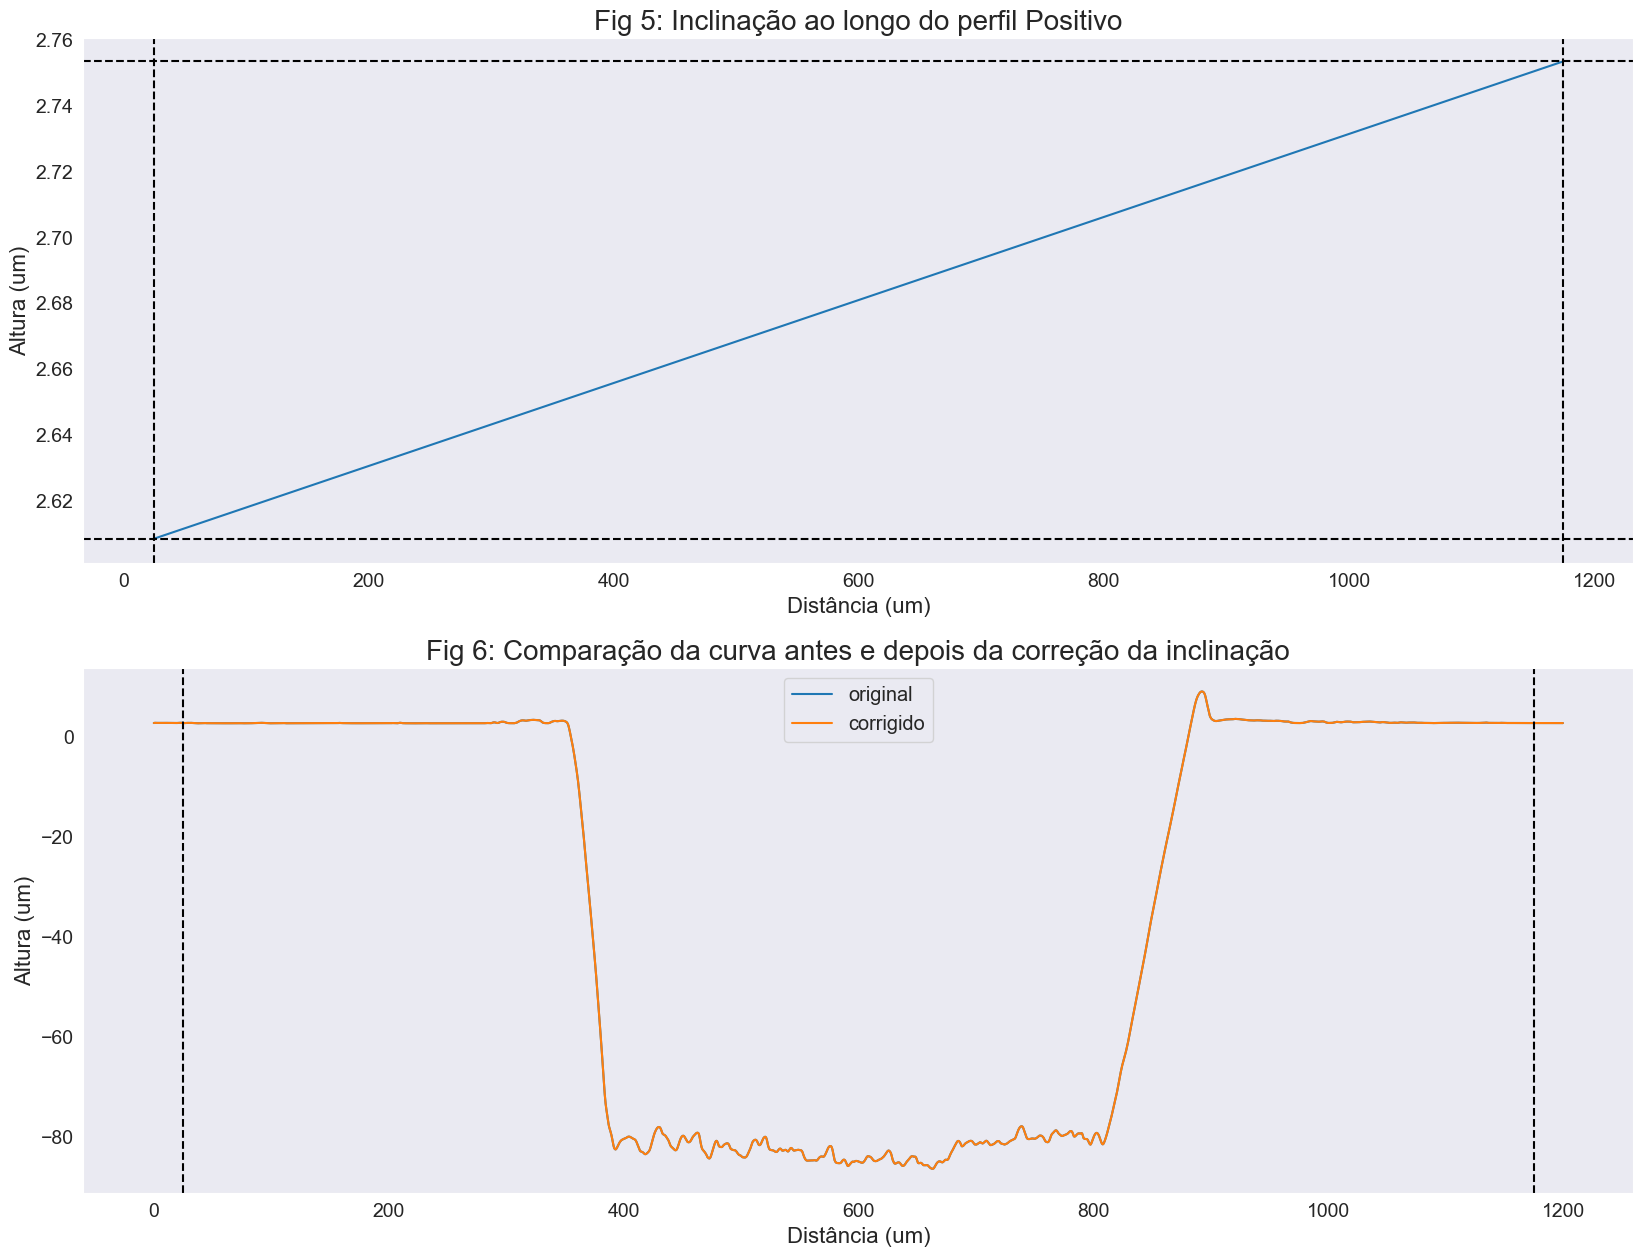

In [8]:
# Célula dedicada para corrigir a inclinação da curva do perfil


aux = pd.Series()                                                                   #Lista auxiliar para armazenar dados temporarios que construirão a nova curva do perfil

#Construção do pontos para calcular a inclinação da reta, "p_x" é um vetor com coordenada "x" dos dois pontos e "p_y" é o vetor com as coordenadas "y"
if Perfil == 'Positivo':
    p_x = [float(y[secao1_comeca+100]),float(y[secao5_termina-100])]                
    p_y = [float(altura[secao1_comeca+100]), float(altura[secao5_termina-100])]
if Perfil == 'Negativo':
    p_x = [float(y[secao3_comeca+100]),float(y[secao3_termina-100])]
    p_y = [float(altura[secao3_comeca+100]), float(altura[secao3_termina-100])]

#Calculo das retas que constrói o triângulo retângulo entre os dois pontos selecionados
d = np.absolute(p_x[0] - p_x[1])                                                    #Distância (cateto adjacente)
h = np.absolute(p_y[0] - p_y[1])                                                    #Altura (cateto oposto)
hip = np.sqrt((d**2)+(h**2))                                                      #Hipostenusa
radianos = np.arcsin(h/hip)                                                        #Inclinação em radianos

#Laço que percorre todos os pontos do perfil e corrige eles utilizando o teorema de tales ("Intercept theorem")
for i in range(len(y)):
    #Condicionamento do calculo de acordo com a posição do ponto atual em relação ao primeiro ponto da reta de cálculo da inclinação
    if y[i] > p_x[0]:   #Ponto atual depois do primeiro ponto da reta de inclinação
        d_ = y[i] - p_x[0]                                                          #Variavel que representa a distância entre o ponto selecionado e o de refêrencia
        h_ = np.float32(radianos*d_)                                                #Variavel que representa a diferença altura entre o ponto selecionado e o de refêrencia
        if Perfil == 'Positivo':
            aux[i] = altura[i] - h_
        if Perfil == 'Negativo':
            aux[i] = altura[i] + h_
    elif y[i] == p_x[0]:    #Ponto atual é o primeiro ponto da reta de inclinação
        aux[i] = altura[i]
        pass
    else:   #Ponto atual antes do primeiro ponto da reta de inclinação
        d_ = p_x[0] - y[i]                                                          #Variavel que representa a distância entre o ponto selecionado e o de refêrencia
        h_ = np.float32(radianos*d_)                                                #Variavel que representa a diferença altura entre o ponto selecionado e o de refêrencia
        if Perfil == 'Positivo':
            aux[i] = altura[i] - h_
        if Perfil == 'Negativo':
            aux[i] = altura[i] + h_

h1 = altura[secao1_comeca+100] - altura[secao5_termina-100]                         #Variavel que armazena a diferença altura entre o ponto selecionado e o de refêrencia antes da correção
h2 = aux[secao1_comeca+100] - aux[secao5_termina-100]                               #Variavel que armazena a diferença altura entre o ponto selecionado e o de refêrencia depois da correção


#laço para substituir os valores antigos da altura pelos novos
for i in range(len(altura)):
    altura[i] = aux[i]

#Plot
fig, axs = plt.subplots(ncols=1,nrows=2, figsize=(20, 15))

figure +=1
sns.lineplot(x = p_x, y = p_y, ax = axs[0])
axs[0].set_title("Fig %d: Inclinação ao longo do perfil %s"%(figure, Perfil), fontsize = 20)
axs[0].set_ylabel("Altura (um)", fontsize = 16)
axs[0].set_xlabel("Distância (um)", fontsize = 16)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].yaxis.set_tick_params(labelsize=14)

axs[0].axhline(p_y[0], color = 'black', linestyle = '--')
axs[0].axhline(p_y[1], color = 'black', linestyle = '--')

axs[0].axvline(p_x[0], color = 'black', linestyle = '--')
axs[0].axvline(p_x[1], color = 'black', linestyle = '--')

figure +=1
sns.lineplot(x=y,y = altura, label = 'original', ax = axs[1])
sns.lineplot(x=y,y=aux, label = 'corrigido', ax = axs[1])
axs[1].set_title("Fig %d: Comparação da curva antes e depois da correção da inclinação"%figure, fontsize = 20)
axs[1].set_ylabel("Altura (um)", fontsize = 16)
axs[1].set_xlabel("Distância (um)", fontsize = 16)
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[1].axvline(p_x[0], color = 'black', linestyle = '--')
axs[1].axvline(p_x[1], color = 'black', linestyle = '--')

axs[1].legend(fontsize = 'x-large')


plt.show()

Utilizei o teorema de pitagoras para construir o triângulo retângulo representado na figura 5, com isso é possivel aferir o angulo de inclinação da reta (cateto/hipotenusa) e com a inclinação da reta é possivel aplicar o teorema de tales, utilizando a distância*ângulo para calcular a altura.
Na célula abaixo está exibida a diferença de altura dos pontos antes e depois da normalização da curva.

In [9]:
print("Comparativo da diferença de altura dos pontos nos indices destacados (Linhas pontilhadas verticais):\nOriginal: Diferença = %f\nCorrigido: Diferença = %f"%(np.absolute(h1),h2))

Comparativo da diferença de altura dos pontos nos indices destacados (Linhas pontilhadas verticais):
Original: Diferença = 0.145136
Corrigido: Diferença = 0.000000


Podemos notar que existe a correção na inclinação mas nem sempre é possivel vizualizar na figura 6, por isso torna-se fundamental fazer o comparativo via cálculo.

Dando inicio ao ultimo ajuste na seção em que os cálculos de rugosidade serão realizados. É interessante que dentro da seção recortada temos as duas bordas do corte realizado no substrato, então para isso criei duas funções que percorrem os extremos da seção adicionando pontos (caso a borda esteja fora da seleção) e removendo pontos (caso a borda esteja muito acima do percentil de 95%).

In [10]:
def ApagaPonto(linha, q, countdown, countup): #Função que remove os pontos acima do percentil, parametros explicados no decorrer do código

    #Laço que compara o começo do vetor "linha" com o percentil "q" enviado como parâmetro da função
    while True:
        if linha[0] > q: #Corta o os pontos que são maiores que o percentil "q" 
            linha.pop(0)
            countdown -= 1                                                #Varialvel de apoio que registra quantos pontos foram removidos no inicio da curva
            linha.reset_index(drop = True, inplace= True)
        else:
            #Sai do loop quando não tiver mais pontos maiores que o percentil "q"
            break
    #Laço que compara o final do vetor "linha" com o percentil "q" enviado como parâmetro da função
    while True:
        if linha[len(linha)-1] > q: #Corta o os pontos que são maiores que o percentil "q" 
            linha.pop(len(linha)-1)
            countup -= 1                                                   #Varialvel de apoio que registra quantos pontos foram removidos no final da curva
            linha.reset_index(drop = True, inplace= True)
        else:
            #Sai do loop quando não tiver mais pontos maiores que o percentil "q"
            break
    
    q_novo = linha.quantile(q=0.95)                                        #Varialvel que armazena o novo valor do percentil de 95% da curva
    return linha, q_novo, countdown, countup

def ReconstroiPonto(inicio, fim, linha, q, countdown, countup): #Função que adiciona pontos até atingir a linha de percentil, parametros explicados no decorrer do código

    p = 0                                                                  #Variavel auxiliar para contagem de loops
    aux = pd.Series()                                                      #Vetor auxiliar utilizado para criar o novo vetor após a inclusão de pontos

    #Laço que compara o começo do vetor "linha" com o percentil "q" enviado como parâmetro da função
    while True: 
        if altura[inicio - 1 + countdown - p] < q:
            aux[0] = altura[inicio - 1 + countup - p]
            linha = pd.concat([aux, linha], ignore_index=True)
        else:
            countdown += p
            p = 0
            
            break
        p += 1  

    #Laço que compara o final do vetor "linha" com o percentil "q" enviado como parâmetro da função
    while True:
        if altura[fim + 1 - countup + p] < q:
            aux[0] = altura[fim + 1 - countup + p]
            linha = pd.concat([linha, aux], ignore_index=True)
        else:
            countup += p
            p = 0
            break
        p += 1
    return linha, countdown, countup


Com as funções definidas podemos iniciar a aquisição e correção dos pontos que vão compor a base de cálculos, a célula abaixo é dividida em duas partes, a primeira com a separação dos pontos em seções 1 - 5, e na segunda as funções entram para ajustar a curva que será utilizada nos calculos. O ajuste é feito com base no valor percentil de 95% dos pontos da seção, esse ajuste é executado até que o maior pico da seção (ignorando as paredes) esteja acima do valor do percentil

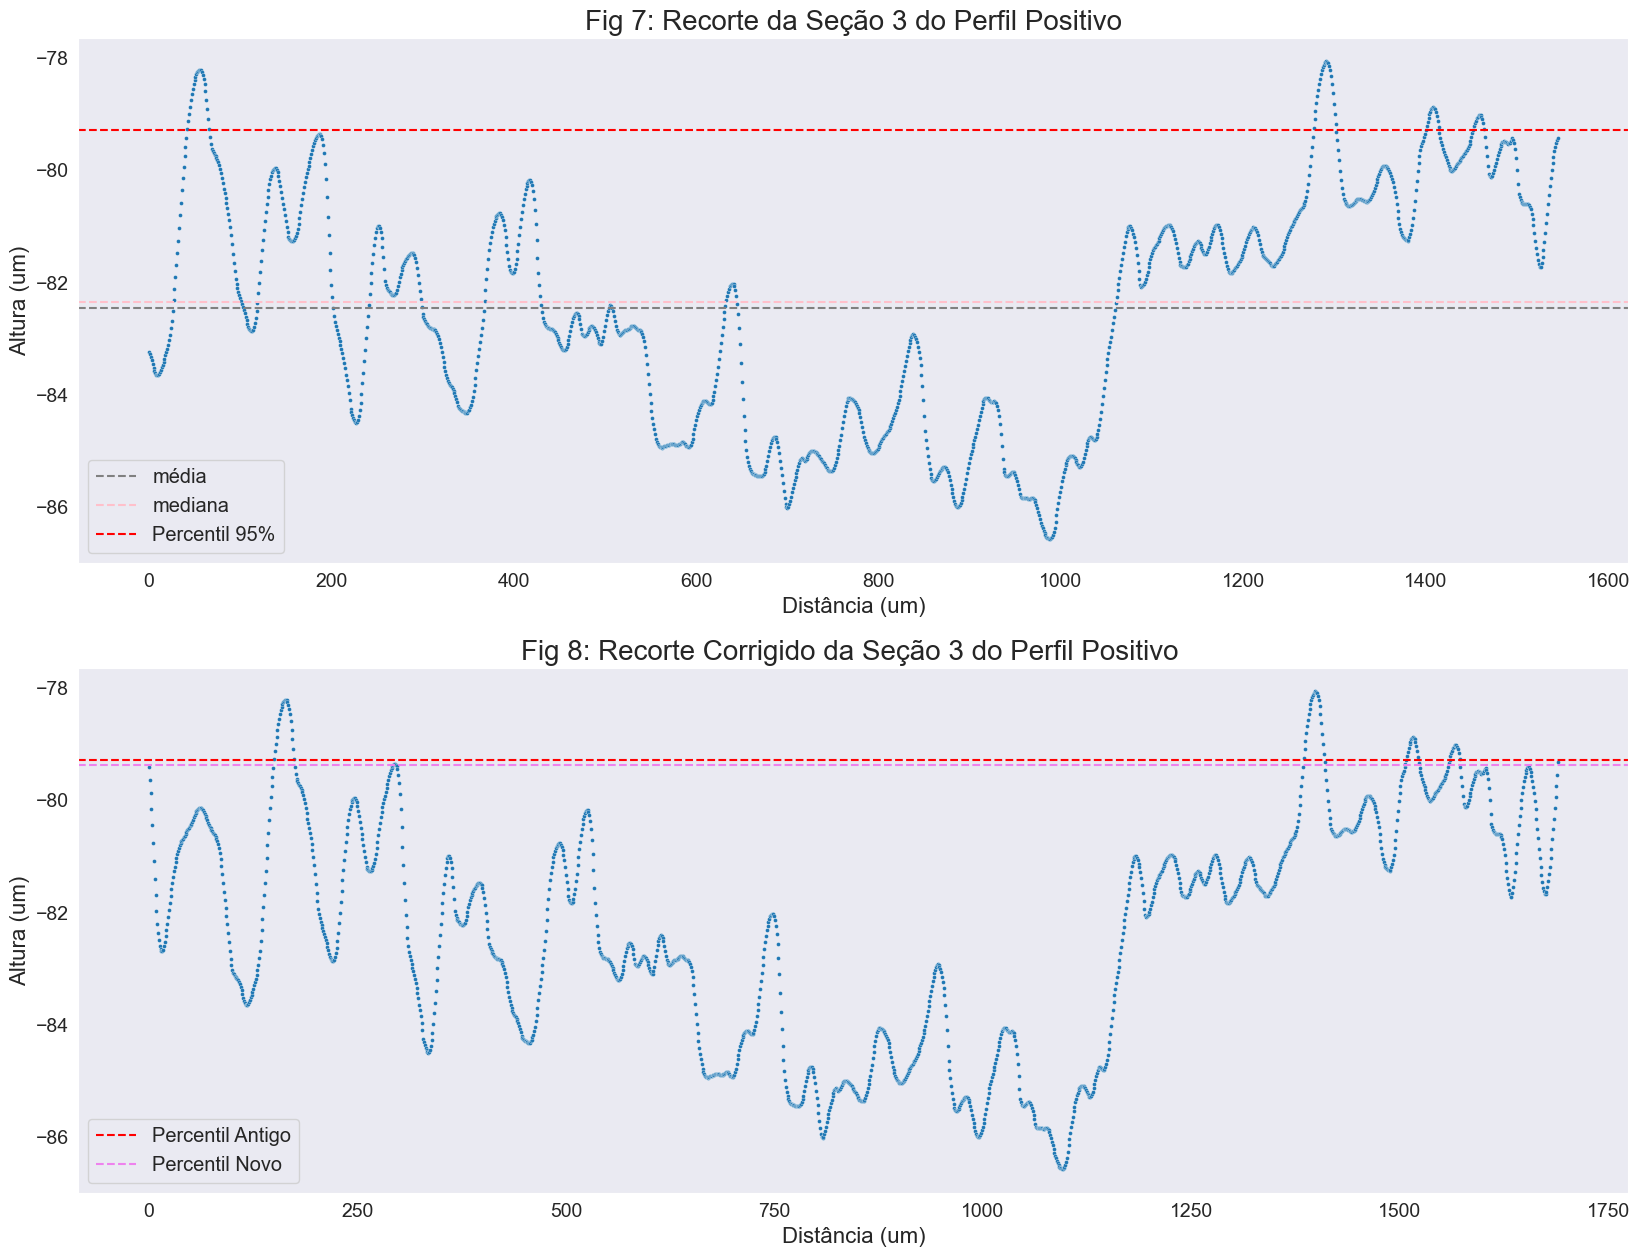

In [11]:
secao1 = pd.Series()                                                                                            #Vetor que armazena os pontos da seção 1
secao2 = pd.Series()                                                                                            #Vetor que armazena os pontos da seção 2
secao3 = pd.Series()                                                                                            #Vetor que armazena os pontos da seção 3
secao4 = pd.Series()                                                                                            #Vetor que armazena os pontos da seção 4
secao5 = pd.Series()                                                                                            #Vetor que armazena os pontos da seção 5

countdown = 0                                                                                                   #Variavel que armazena a quantidade de pontos modificados no inicio da curva
countup = 0                                                                                                     #Variavel que armazena a quantidade de pontos modificados no final da curva

#Caso o perfil seja positivo
if Perfil == 'Positivo':
    alcance = secao3_termina - secao3_comeca                                                                    #Variavel que determina a quantidade de loops do laço

    #Laço para adicionar os pontos da seção 3 no vetor de mesmo nome
    for i in range(alcance):
        secao3[i] = altura[i + secao3_comeca]
    linha = secao3                                                                                              #Vetor temporario utilizado na modificação dos pontos para não danificar o original
    s = "Seção 3"                                                                                               #Variavel que armazena o nome da seção de importancia em cada caso
    q = linha.quantile(q = 0.95)                                                                                #Variavel que armazena o percentil de 95% dos pontos da seção

#Caso o perfil seja positivo
if Perfil == 'Negativo':
    alcance = secao1_termina - secao1_comeca                                                                    #Variavel que determina a quantidade de loops do laço
    
    #Laço para adicionar os pontos da seção 1 no vetor de mesmo nome
    for i in range(alcance):
        secao1[i] = altura[i + secao1_comeca]
    
    alcance = secao5_termina - secao5_comeca                                                                    #Variavel que determina a quantidade de loops do laço
    
    #Laço para adicionar os pontos da seção 5 no vetor de mesmo nome
    for i in range(alcance):
        secao5[i] = altura[i + secao5_comeca]

    linha = pd.concat([secao5, secao1], ignore_index=True)                                                      #Vetor temporario utilizado na modificação dos pontos para não danificar o original
    s = "Seção 5 + Seção 1"                                                                                     #Variavel que armazena o nome da seção de importancia em cada caso
    q = linha.quantile(q = 0.95)                                                                                #Variavel que armazena o percentil de 95% dos pontos da seção

#plot 1
fig, axs = plt.subplots(ncols=1,nrows=2, figsize=(20, 15))

sns.scatterplot(linha,s = 8.5, ax = axs[0])
figure += 1
axs[0].set_title("Fig %d: Recorte da %s do Perfil %s"%(figure, s, Perfil), fontsize = 20)
axs[0].set_ylabel("Altura (um)", fontsize = 16)
axs[0].set_xlabel("Distância (um)", fontsize = 16)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].yaxis.set_tick_params(labelsize=14)

axs[0].axhline(y = linha.mean(),c='gray', linestyle = "--", label = "média")
axs[0].axhline(y = linha.median(),c='pink', linestyle = "--", label = "mediana")
axs[0].axhline(y = linha.quantile(q = 0.95),c='r', linestyle = "--", label = "Percentil 95%")
axs[0].legend(fontsize = 'x-large')

#Manipulação dos pontos na seção de interesse para os calculos

#Condição para definição dos pontos iniciais e finais da seção
if Perfil == 'Positivo':
    inicio = secao3_comeca + countup
    fim = secao3_termina + countdown
elif Perfil == 'Negativo':
    inicio = secao5_comeca + countup
    fim = secao1_termina + countdown


linha, countdown, countup = ReconstroiPonto(inicio, fim, linha, q, countdown, countup)  #Chamada da função "ReconstroiPonto"

linha, q_novo, countdown, countup = ApagaPonto(linha, q, countdown, countup) #Chamada da função "ApagaPonto"

inicio += countup   #Mudança do ponto inicial para o do novo vetor
fim += countdown    #Mudança do ponto final para o do novo vetor
aux = pd.Series()                                                                                               #Vetor auxiliar que armazena os pontos para realizar a segunda filtragem

#Laço para montar o vetor auxiliar
for i in range(len(linha)):
    if i < 100 or i > len(linha) - 150: #Filtra os pontos com a finalidade de ter só o miolo do vetor "linha"
        aux[i] = linha.min()
    else:
        aux[i] = linha[i]

a = 0
#Laço para deleter e reconstruir os pontos de acordo com o novo valor percentil de 95%
while True:
    
    if (aux.max() <= q_novo):
        linha, q_novo, countdown, countup = ApagaPonto(linha, q_novo, countdown, countup)
        inicio += countup
        fim += countdown
        a = 1
    if a == 1:
        linha, countdown, countup = ReconstroiPonto(inicio, fim, linha, q_novo, countdown, countup)
    else:
        break


#plot 2
sns.scatterplot(linha, s = 8.5, ax=axs[1])
figure += 1
axs[1].set_title("Fig %d: Recorte Corrigido da %s do Perfil %s "%(figure, s, Perfil), fontsize = 20)
axs[1].set_ylabel("Altura (um)", fontsize = 16)
axs[1].set_xlabel("Distância (um)", fontsize = 16)
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[1].axhline(q, color = 'r', linestyle = "--", label = "Percentil Antigo")
axs[1].axhline(q_novo, color = 'violet',linestyle = "--", label = "Percentil Novo")
axs[1].legend(fontsize = 'x-large')

plt.show()
